# Analysis

In [32]:
import ast
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Import and preprocessing for updated csv's

In [2]:
# Set various data and figure directories relative to cwd
# (which is hopefully always this file's dirname)
cwd = os.getcwd()
root = os.path.split(os.path.split(cwd)[0])[0]
rawdir = os.path.join(root, "data/raw") # Raw csv files; local only!
tmpdir = os.path.join(root, "data/tmp") # Intermediate data products; local only!
extdir = os.path.join(root, "data/external") # Data from external sources; in repo
cleandir = os.path.join(root, "data/cleaned") # Data for dashboard generation; in repo
figdir = os.path.join(root, "figures") # Final figures; in repo

In [3]:
# Set raw csv data file paths
docketcsv = "docket_reparse_03_02_2021.csv"
courtcsv = "court_summary.csv"

docketpath = os.path.join(rawdir, docketcsv)
courtpath = os.path.join(rawdir, courtcsv)

In [4]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv(docketpath, index_col = 0)
courtdf = pd.read_csv(courtpath, index_col=0)
df = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
df.reset_index(inplace=True)
df.drop(columns=['docket_no'], inplace=True)
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [5]:
# Fill empty bail_type with 'Denied'
df[['bail_type']] = df[['bail_type']].fillna('Denied')

In [6]:
# Correct 'Emergency Arraignment Court Magistrate' to 'E-Filing Judge'
df['bail_set_by'] = df['bail_set_by'].apply(lambda x: 'E-Filing Judge' if x == 'Emergency Arraignment Court Magistrate' else x)

In [7]:
df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = df["prelim_hearing_dt"].apply(
    lambda x: str(x).split(' ')[0] if pd.notnull(x) else x) # This is here because of a parsing issue
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# Convert string representations of lists to lists
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df['offense_type'] = df['offense_type'].apply(lambda x: ast.literal_eval(x))
df['statute'] = df['statute'].apply(lambda x: ast.literal_eval(x))

# Create age column
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# Create public defender column: 1 if public defender, 0 if private defender
# note that there is also an "attorney_type" column, with "Public", "Private", and "Court Appointed" options
#df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# Create clean zipcode column: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in Philadelphia
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

# Create categorical column indicating if bail is paid
df['bail_paid_YN'] = df['bail_paid'].apply(lambda x: "no" if x == 0 else "yes")

In [8]:
# Define bins for bail amount
# Note that these are somewhat arbitrary, though roughly in order-of-magnitude increments
def bin_bailSet(bailSet):
    if bailSet == 0 or pd.isnull(bailSet):
        return 'None'
    elif bailSet < 1000:
        return '<1k'
    elif bailSet < 5000:
        return '1k to 5k'
    elif bailSet < 10000:
        return '5k to 10k'
    elif bailSet < 25000:
        return '10k to 25k'
    elif bailSet < 50000:
        return '25k to 50k'
    elif bailSet < 100000:
        return '50k to 100k'
    elif bailSet < 500000:
        return '100k to 500k'
    else:
        return '>=500k'

# TODO: auto-generate bail_bin_labels to not have to manually update if updating fcn above
bail_bin_labels = ['None', '<1k', '1k to 5k', '5k to 10k', '10k to 25k', '25k to 50k', '50k to 100k', '100k to 500k', '>=500k']   
    
# Create column for bail amount bins
df['bail_set_bin'] = df['bail_amount'].apply(lambda x: bin_bailSet(x))

In [9]:
# Define bins for age group
def bin_age(age):
    if age < 18:
        return 'minor'
    elif age < 26:
        return '18 to 25'
    elif age < 34:
        return '26 to 33'
    elif age < 42:
        return '34 to 41'
    elif age < 50:
        return '42 to 49'
    elif age < 58:
        return '50 to 57'
    elif age < 65:
        return '58 to 64'
    else:
        return 'senior'

# Create column for bail amount bins
df['age_group'] = df['age'].apply(lambda x: bin_age(x))

In [10]:
# create columns for each statute

# number of different offenses (statutes) represented
all_statutes = []
for i in range(df.shape[0]):
    statutes = df.at[i,'statute']
    for item in statutes:
        if item not in all_statutes:
            all_statutes.append(item)
            
n_statutes = len(all_statutes)
print('number of statutes: ', n_statutes)

# create a dictionary of feature: statute 
statute_dict = {}
feature_statute = {}
for i, item in enumerate(all_statutes):
    statute_dict[i] = item
    feature_statute[item] = i
    
statute_cols = ['statute_' + str(i) for i in range(len(all_statutes))]

# create new columns, one for each statute
df[statute_cols] = 0

for i in range(df.shape[0]):
    statutes = df.at[i,'statute']
    for item in statutes:
        statute_idx = 'statute_' + str(all_statutes.index(item))
        df.loc[i, statute_idx] += 1
        

number of statutes:  517


In [11]:
# full list of columns available to work with
sorted(df.columns.tolist())

['age',
 'age_group',
 'arrest_dt',
 'arresting_officer',
 'attorney',
 'attorney_type',
 'bail_amount',
 'bail_date',
 'bail_paid',
 'bail_paid_YN',
 'bail_set_bin',
 'bail_set_by',
 'bail_type',
 'case_status',
 'dob',
 'offense_date',
 'offense_type',
 'offenses',
 'philly_zipcode',
 'prelim_hearing_dt',
 'prelim_hearing_time',
 'race',
 'sex',
 'statute',
 'statute_0',
 'statute_1',
 'statute_10',
 'statute_100',
 'statute_101',
 'statute_102',
 'statute_103',
 'statute_104',
 'statute_105',
 'statute_106',
 'statute_107',
 'statute_108',
 'statute_109',
 'statute_11',
 'statute_110',
 'statute_111',
 'statute_112',
 'statute_113',
 'statute_114',
 'statute_115',
 'statute_116',
 'statute_117',
 'statute_118',
 'statute_119',
 'statute_12',
 'statute_120',
 'statute_121',
 'statute_122',
 'statute_123',
 'statute_124',
 'statute_125',
 'statute_126',
 'statute_127',
 'statute_128',
 'statute_129',
 'statute_13',
 'statute_130',
 'statute_131',
 'statute_132',
 'statute_133',
 'stat

In [12]:
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,statute_507,statute_508,statute_509,statute_510,statute_511,statute_512,statute_513,statute_514,statute_515,statute_516
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"[75 § 3802, 75 § 3323]",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,0,0,0,0,0,0,0,0,0,0
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,0,0,0,0,0,0,0,0,0,0
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,[18 § 3929],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,0,0,0,0,0,0,0,0,0,0
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"[18 § 2701, 18 § 2705]","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,0,0,0,0,0,0,0,0,0,0
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"[18 § 3701 §§ A1IV, 18 § 903 §§ C, 18 § 3921 §...","[robbery, inchoate crimes, theft and related o...",No Magistrate Found,30000.0,0.0,2020-01-01,...,0,0,0,0,0,0,0,0,0,0


## Preliminary analysis

## Q1.1

## Q1.2 

## Q1.3 What neighborhoods are highly impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


## Q2.1 Relationship between bail type / amount and various factors

### Q: Are bail type and attorney type related?

In [13]:
df_attorney = pd.crosstab(index = df['attorney_type'], columns =df['bail_type'])
df_attorney

bail_type,Denied,Monetary,Nonmonetary,ROR,Unsecured
attorney_type,,,,,
Court Appointed,123,1208,7,382,578
Private,160,3658,7,878,782
Public,51,6783,149,5471,3605


In [15]:
# since there are only a few nominal and non-monetary, combine them into 'other'
df_attorney['Other'] = df_attorney['Nominal'] + df_attorney['Nonmonetary']

KeyError: 'Nominal'

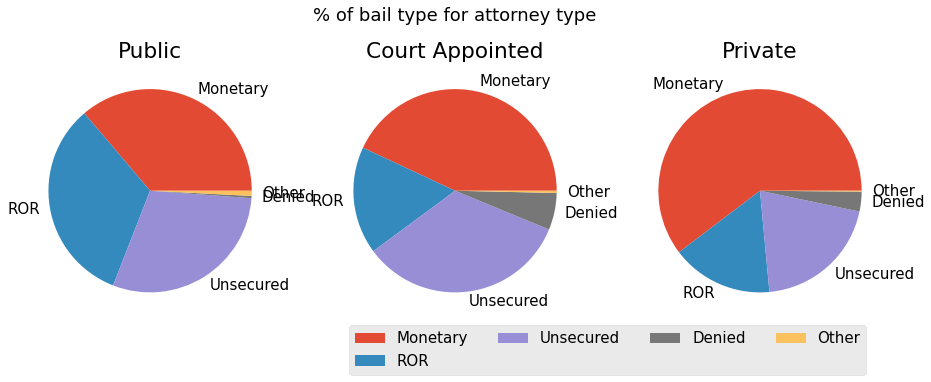

In [73]:
bail_types = ['Monetary','ROR', 'Unsecured', 'Denied','Other']
fig, ax = plt.subplots(ncols = 3, figsize = (15, 15))
plt.rcParams['font.size'] = 15
fig.suptitle('% of bail type for attorney type')
ax[0].pie(df_attorney.loc['Public',bail_types], labels = bail_types)
ax[0].set_title('Public')
ax[1].pie(df_attorney.loc['Court Appointed',bail_types], labels = bail_types)
ax[1].set_title('Court Appointed')
ax[2].pie(df_attorney.loc['Private',bail_types], labels = bail_types)
ax[2].set_title('Private')
# common legend
fig.subplots_adjust(top=1.5, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(1.1, 0), ncol=4)

plt.show()

In [16]:
# remove 'nominal' since we don't have enough cases 
df_attorney.drop(columns = ['Nominal', 'Nonmonetary', 'Other'], inplace = True)

# chi-squared test: Whether someone 
chi2, p, dof, ex = chi2_contingency(df_bail_attorney)
print('p-value of chi-square test: ', p)

KeyError: "['Nominal' 'Other'] not found in axis"

* chi-square test tells us that **bail type and attorney type are related.**  
* Looking at the pie chart for cases with public defenders, around 1/3 of cases end up with monetary, ROR, or unsecured bail. In contrast, cases with private attorney representation ends up with higher proportion of monetary bail cases. 
* This might be because defendants with serious offenses (and therefore more likely to end up with monetary bail) may be more likely to seek representation by private attornies.

### Q: Is bail amount and attorney type related?

In [17]:
df_monetary = df[df['bail_type'] == 'Monetary'][['attorney_type', 'bail_amount']]

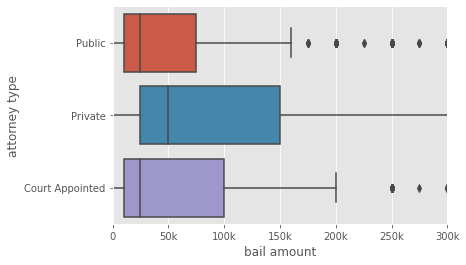

In [126]:
ax = sns.boxplot(x = 'bail_amount', y = 'attorney_type', data = df_monetary)
ax.set_xlim((0,300000))
ax.set_xticks(ticks = range(0, 350000, 50000))
ax.set_xticklabels(['0','50k','100k','150k','200k','250k','300k'])
ax.set_xlabel('bail amount')
ax.set_ylabel('attorney type')
plt.show()

In [127]:
print('Median monetary bail amount for cases with public attorney: ', df_monetary[df_monetary['attorney_type'] == 'Public'].bail_amount.median())
print('Median monetary bail amount for cases with court appointed defender: ', df_monetary[df_monetary['attorney_type'] == 'Court Appointed'].bail_amount.median())
print('Median monetary bail amount for cases with private attorney: ', df_monetary[df_monetary['attorney_type'] == 'Private'].bail_amount.median())


Median monetary bail amount for cases with public attorney:  25000.0
Median monetary bail amount for cases with court appointed defender:  25000.0
Median monetary bail amount for cases with private attorney:  50000.0


* It seems like cases with private attornies have **higher monetary bail amount**.
* This may be due to the fact that defendants with serious offenses are more likely to hire private attornies.

## Q2.2

## Q2.3 What are the strongest factors determining bail type / bail amount?

* See Q2.1 for starters

Potential targets:
* bail amount
* bail set bin
* bail paid (yes/no)
* bail type

### Q2.3 a: bail type

### Prepare features

In [18]:
df.drop(columns = ['dob', 'arresting_officer', 'attorney', 'zip'], inplace = True)

### Correlations among categorical variables  
* Look at correlations among variables.  
* Use to select features for the predictive model
* Categorical variables to consider:
    * bail type
    * attorney type
    * arresting officer
    * magistrate 
    * zipcode
* Variables to add later: race, gender, offense type

In [76]:
def compute_cramers_V(contingency_table):
    # comptues Cramers'V measure from the given table
    # contingency_table: dataframe
    
    chi2 = chi2_contingency(contingency_table)[0]
    
    # sample size
    N = np.array(contingency_table).sum()
    k = min(contingency_table.shape)
    return np.sqrt(chi2 / (N*(k-1)))

In [121]:
def compute_cramersV_matrix(df, columns):
    # columns: list of columns of df with categorical variables
    n_variables = len(columns)
    V_matrix = np.identity(n_variables)
    
    for pair in itertools.combinations(range(n_variables),2):
        var1, var2 = pair
        cramersV = compute_cramers_V(pd.crosstab(index = df[columns[var1]], columns = df[columns[var2]]))
        V_matrix[var1, var2] = cramersV
        V_matrix[var2, var1] = cramersV

    return V_matrix

In [122]:
variables = ['public_defender', 'bail_type', 'zipcode_clean','arresting_officer', 'bail_set_by']
V_matrix = compute_cramersV_matrix(df, variables)

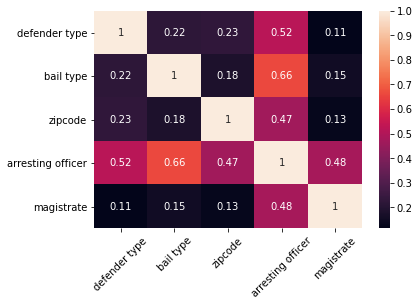

In [123]:
labels = ['defender type', 'bail type', 'zipcode', 'arresting officer', 'magistrate']
g = sns.heatmap(V_matrix, annot = True)
g.set_xticklabels(labels, rotation = 45)
g.set_yticklabels(labels, rotation = 0)
plt.show()

* Cramer's V score: [0,1], with 0: no association, 1: strong association
* It looks like 'arresting officer' is highly correlated with other variables. Probably because officers are in charge of specific types of offenses.  
* Caution: this correlation matrix doesn't remove low-frequency rows/columns during chi-square test. To validate results, should perform chi-square after adjusting frequency.
    * Ex) zipcode, arresting officer, and magistrate probably have a lot of low frequency categories

### Predictive Modeling

#### Review Columns

Arrest Date

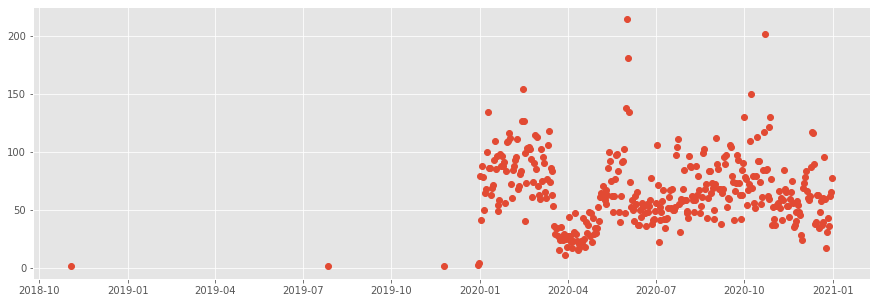

In [19]:
x = df['arrest_dt'].value_counts().index
y = df['arrest_dt'].value_counts().values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

Offense Date

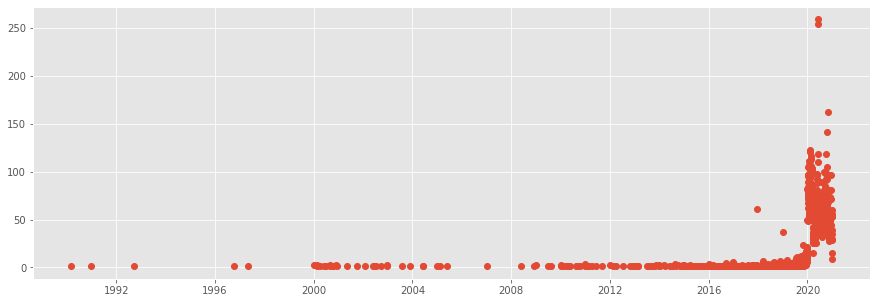

In [20]:
x = df['offense_date'].value_counts().index
y = df['offense_date'].value_counts().values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

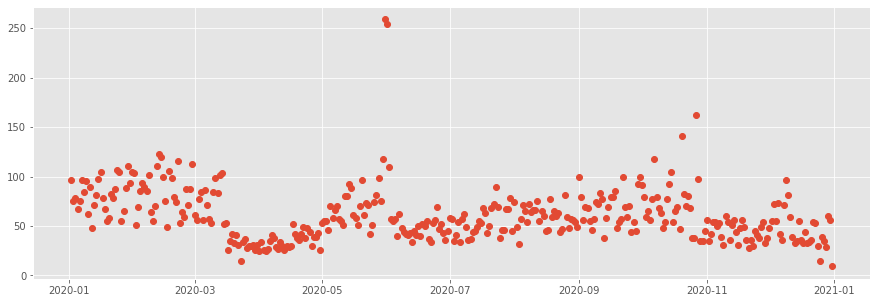

In [21]:
filtered_count = df[df['offense_date'] > datetime(2020, 1, 1)]['offense_date'].value_counts()

x = filtered_count.index
y = filtered_count.values

plt.figure(figsize=(15,5))
plt.plot_date(x, y)

# date or date range (e.g. month, quarter) not a very interpretable feature
# consider using day of the week

Bail Date

TODO
* Look into what bail date is referring to (date bail is assigned? date bail is paid?)

Attorney Type

In [22]:
df['attorney_type'].value_counts()

Public             16059
Private             5485
Court Appointed     2298
Name: attorney_type, dtype: int64

Magistrate ('bail_set_by' column)

* Use top magistrates from earlier analysis (bucket rest into "other")?

In [23]:
df['bail_set_by'].value_counts()

O'Brien, James                4520
Bernard, Francis X.           4460
Stack, Patrick                4063
E-Filing Judge                3488
Rigmaiden-DeLeon, Marilyn     1761
Rainey, Debra                 1107
Williams, Naomi                992
Connor, Lauren                 985
Devlin, Kevin R.               899
No Magistrate Found            734
Rodriguez, Teresa              221
Bass, Sheldon                  189
Ebert, Stefanie                185
Caudo, Michael A.              143
Capone, Joseph P.              138
Hope, Christine M.              74
Wolf, Matthew S.                65
Conroy, David H.                62
Lewandowski, Henry 3rd          50
Pittman, Joffie C. III          28
Bryant-Powell, Crystal          18
DeLeon, James M.                12
Lynn, James Murray              10
Meehan, William Austin Jr.       6
Bedford, Sheila M.               5
Frazier-Lyde, Jacquelyn          4
Neifield, Marsha H.              3
Pew, Wendy L.                    3
Simmons, Karen Y.   

Zipcode

* Group areas?

In [24]:
df['zipcode_clean'].nunique()

648

Age Group

In [28]:
df['age_group'].value_counts()

26 to 33    7170
18 to 25    6926
34 to 41    4681
42 to 49    2573
50 to 57    1725
58 to 64     755
senior       275
minor        135
Name: age_group, dtype: int64

Preliminary Hearing Date & Time

*Exclude from modeling*

* Bail is determined at initial appearance/arraignment, not at preliminary hearing ([American Bar](https://www.americanbar.org/groups/public_education/resources/law_related_education_network/how_courts_work/pretrial_appearances/#:~:text=The%20matter%20is%20set%20for,sets%20the%20amount%20of%20bail.))
* Preliminary hearings only apply to felonies ([American Bar](https://www.americanbar.org/groups/public_education/resources/law_related_education_network/how_courts_work/pretrial_appearances/#:~:text=The%20matter%20is%20set%20for,sets%20the%20amount%20of%20bail.))
* Prelims only happen when the defendant pleads not guilty in arraignment ([Nolo](https://www.nolo.com/legal-encyclopedia/all-about-preliminary-hearings-or-prelims.html))
* Defendant may make motion to reduce bail at prelims ([PA law firm](https://goldsteinmehta.com/blog/what-happens-at-the-preliminary-hearing))

Features to include in model:
* age group
* ~~arrest date weekday~~
* attorney type
* ~~magistrate, i.e. bail_set_by (must be grouped)~~
* offense type
* race
* sex

**Prepare data for modeling**

In [21]:
model_df = df.loc[:, ['bail_type', 'age_group', 'attorney_type', 'offense_type', 'race', 'sex']].explode('offense_type').copy()

model_df.head()

,bail_type,age_group,attorney_type,offense_type,race,sex
0,ROR,18 to 25,Public,driving after imbibing alcohol or utilizing drugs,White,Male
0,ROR,18 to 25,Public,general traffic offense,White,Male
1,ROR,18 to 25,Private,driving after imbibing alcohol or utilizing drugs,White,Male
2,ROR,50 to 57,Public,theft and related offenses,Black,Male
3,Monetary,26 to 33,Public,assault,Black,Male


In [22]:
# find least common offense_type value

model_df['offense_type'].value_counts()

assault                                                          21121
drug and substance                                               12964
inchoate crimes                                                  10936
firearms and other dangerous articles                             9689
theft and related offenses                                        9396
burglary and other criminal intrusion                             4282
arson, criminal mischief, and other property destruction          2222
driving after imbibing alcohol or utilizing drugs                 1941
sexual offenses                                                   1587
robbery                                                           1396
falsification and intimidation                                    1144
general traffic offense                                           1051
domestic relations and abuse                                       992
obstructing governmental operations                                912
forger

In [23]:
model_df = model_df.loc[model_df['offense_type'] != 'NA']

In [24]:
# drop rows with unknown values and least common category
# least likely to get information in model from least common category (not enough data)

model_df = model_df.loc[model_df['offense_type'] != 'human trafficking']
model_df = model_df.loc[model_df['age_group'] != 'minor']
model_df = model_df.loc[model_df['attorney_type'] != 'Court Appointed']
model_df = model_df.loc[(model_df['race'] != 'Unknown/Unreported') & (model_df['race'] != 'Bi-Racial')]
model_df = model_df.loc[model_df['sex'] == 'Male']

In [25]:
model_df = pd.get_dummies(model_df, columns = ['age_group', 'attorney_type', 'race', 'sex', 'offense_type'])

In [26]:
model_df.head()

,bail_type,age_group_18 to 25,age_group_26 to 33,age_group_34 to 41,age_group_42 to 49,age_group_50 to 57,age_group_58 to 64,age_group_senior,attorney_type_Private,attorney_type_Public,...,"offense_type_riot, disorderly conduct and related offenses",offense_type_robbery,offense_type_serious traffic offense,offense_type_sexual offenses,offense_type_theft and related offenses,offense_type_trade and commerce,offense_type_unknown statute,offense_type_vehicle chop shop and illegally obtained and altered property,offense_type_vehicles: lighting equipment,offense_type_vehicles: other required equipment
0,ROR,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,ROR,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,ROR,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,ROR,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Monetary,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Check for multicollinearity**

In [27]:
vif_df = add_constant(model_df.drop(columns = ['bail_type']))

pd.Series(
    [
        variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])
    ], index = vif_df.columns
)

/Users/wasilaq/opt/anaconda3/envs/pbf/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/wasilaq/opt/anaconda3/envs/pbf/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


age_group_18 to 25                                                                   inf
age_group_26 to 33                                                                   inf
age_group_34 to 41                                                                   inf
age_group_42 to 49                                                                   inf
age_group_50 to 57                                                                   inf
age_group_58 to 64                                                                   inf
age_group_senior                                                                     inf
attorney_type_Private                                                          12.681540
attorney_type_Public                                                           12.719864
race_Asian/Pacific Islander                                                    53.140721
race_Black                                                                    868.079539
race_Native American/

In [30]:
# drop additional columns, drop all offense types with less than 10 instances

colinear_features = ['race_White', 'attorney_type_Private', 'age_group_senior', 'offense_type_bribery and corrupt influence', 'offense_type_vehicle chop shop and illegally obtained and altered property', 'offense_type_trade and commerce', 'offense_type_abuse of office', 'offense_type_computer offense']

vif_df = add_constant(model_df.drop(columns = ['bail_type'] + colinear_features))

pd.Series(
    [
        variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])
    ], index = vif_df.columns
)

age_group_18 to 25                                                        22.851712
age_group_26 to 33                                                        22.383033
age_group_34 to 41                                                        16.114302
age_group_42 to 49                                                        10.089745
age_group_50 to 57                                                         7.351366
age_group_58 to 64                                                         3.839864
attorney_type_Public                                                       1.095947
race_Asian/Pacific Islander                                                1.062328
race_Black                                                                 1.071807
race_Native American/Alaskan Native                                        1.003080
sex_Male                                                                   8.463943
offense_type_accidents report                                              8

In [31]:
# drop additional columns

colinear_features += ['age_group_18 to 25', 'offense_type_assault']

vif_df = add_constant(model_df.drop(columns = ['bail_type'] + colinear_features))

pd.Series(
    [
        variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])
    ], index = vif_df.columns
)

age_group_26 to 33                                                       1.369731
age_group_34 to 41                                                       1.334875
age_group_42 to 49                                                       1.223995
age_group_50 to 57                                                       1.160869
age_group_58 to 64                                                       1.072877
attorney_type_Public                                                     1.094832
race_Asian/Pacific Islander                                              1.062285
race_Black                                                               1.071365
race_Native American/Alaskan Native                                      1.003062
sex_Male                                                                 0.035458
offense_type_accidents report                                            1.009558
offense_type_arrest prior to requisition                                 1.016067
offense_type_ars

In [ ]:
model_df.drop(columns = colinear_features, inplace = True)

### Q2.3 b bail amount

## Q2.4